In [1]:
import torch
import torchvision
import torchvision.transforms as transforms
import numpy as np
import matplotlib.pyplot as plt
import torch.nn as nn 
import torch.nn.functional as F

In [2]:
#step 1 Loading the data ad preprocessing
local_address=r'/home/uzair/Desktop/my_programming_notebook/Main/'
train_data=torchvision.datasets.ImageFolder(root=((local_address) + 'train/') ,
                                            transform=transforms.Compose([transforms.Resize((128,128)),transforms.ToTensor(),transforms.Normalize([0.485, 0.456, 0.406], [0.229, 0.224, 0.225])]))
test_data=torchvision.datasets.ImageFolder(root=((local_address)+'val/'),
                                           transform=transforms.Compose([transforms.Resize((128,128)),transforms.ToTensor(),transforms.Normalize([0.485, 0.456, 0.406], [0.229, 0.224, 0.225])]))
train_loader=torch.utils.data.DataLoader(train_data,batch_size=8,
                                         shuffle=True,
                                         num_workers=4)
test_loader=torch.utils.data.DataLoader(test_data,batch_size=2,
                                        shuffle=True,
                                        num_workers=4)
complete_data_dictionary={'train': train_loader , 'test': test_loader}
print(complete_data_dictionary)

{'train': <torch.utils.data.dataloader.DataLoader object at 0x7f468e2f8cc0>, 'test': <torch.utils.data.dataloader.DataLoader object at 0x7f468e2b9940>}


In [3]:
print(len(train_loader))
batch=next(iter(test_data))
print(len(train_data))
print(len(test_data))

5938
47500
4999


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


torch.Size([8, 3, 128, 128])
8


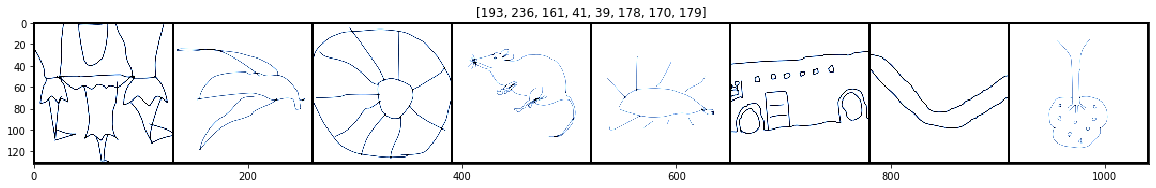

In [4]:
#step 2 Visualizing the data
def view_data(loaded_data):
    batch=next(iter(loaded_data))
    images,labels=batch
    print(images.shape)
    print(images.shape[0])
    my_grid=torchvision.utils.make_grid(images,nrow=images.shape[0])
    plt.figure(figsize=(20,20))
    plt.imshow(np.transpose(my_grid,(1,2,0)))
    plt.title([x.item() for x in labels])
view_data(train_loader)

device=torch.device("cuda:0" if torch.cuda.is_available() else "cpu")
#device=torch.device("cpu")

In [5]:
#step 3 Making a training loop function which accepts the following parameters
# learning_rate,scheluder,model,test_data,train_data
#if input is training data , we need both forward and backward pass.
#If data is for validation, we need only forward pass

def my_train_model(model,data,optimize,given_loss,scheduler,total_epochs=10):
    #making variables for plotting of graphs at later visualization stage
    train_loss , train_acc, val_loss, val_accuracy = [],[],[],[]
    #first epochs , then another loop in each epoch to cover training data
    #in each epoch,first train the model , and then run the validation data to test accuracy
    #ptimizer=optimize(model.parameters(),lr=learning_rate)
    my_sizes={ 'train': len(train_data), 'test' : len(test_data)}
    #first loop for the epochs
    for i in range (total_epochs):
        print('EPOCH NO:' + str(i) )
        
        
            # decrease the learning rate after every given no of epochs
        
        #now second loop for complete loop over a training/validation data
        #each epoch will run two times , one for the training , 2nd for the validation
        
        for current_run in ['train' , 'test']:
            current_epoch_loss=0.0
            total_correct=0.0
            
            if current_run=='train':
                model.train()       #run the model in the training mode 
                scheduler.step()
            else: 
                model.eval()   #run model in validation mode
            
            for batch in data[current_run]:
                
                
                #now performing the forward steps 
                input_data,labels=batch
                #put data into GPU processing if available
                input_data=input_data.to(device)
                labels=labels.to(device)
                
                #print(current_run)
                
                #now for validation , only forward pass is required
                with torch.set_grad_enabled(current_run=='train'):
                    #forward pass
                    my_prediction=model(input_data)
                    #find loss
                    loss=given_loss(my_prediction,labels)
                    #clear previous gradients
                    #Run backward for only training time
                    if current_run=='train':
                        optimizer.zero_grad()
                        #update gradients
                        loss.backward()
                        optimizer.step()
                    
                    
                    
                    current_epoch_loss +=loss.item()*input_data.size(0)
                    total_correct+=my_prediction.argmax(dim=1).eq(labels).sum().item()
                    
                    
                    
                
            #now printing the loss after 1 epoch
                
            print(str(current_run) + '  loss = '  + str(current_epoch_loss))
            print(str(current_run) + ' Accuracy= ' +  str(total_correct/my_sizes[current_run]))
            if current_run=='train':
                        train_acc.append(total_correct/my_sizes[current_run])
                        train_loss.append(current_epoch_loss/my_sizes[current_run])
            else:
                val_accuracy.append(total_correct/my_sizes[current_run])
                val_loss.append(current_epoch_loss/my_sizes[current_run])
            
            
    
    

In [6]:
#Now making arguments for above ftn
no_of_classes=250

model1=torchvision.models.resnet50(pretrained=True)
#changing the model according to our data little_bit
input_features_of_last_layer=model1.fc.in_features
model1.fc=nn.Linear(in_features=input_features_of_last_layer,out_features=no_of_classes)
#model.fc.out_features=no_of_classes
learning_rate1=0.001
my_loss=nn.CrossEntropyLoss()
optimizer=torch.optim.Adam(model1.parameters(),lr=learning_rate1)
dynamic_learning_rate=torch.optim.lr_scheduler.StepLR(optimizer,step_size=7,gamma=0.1)
# my_train_model(model=model1.cuda(),
#                data=complete_data_dictionary,
#                optimize=optimizer,
#                given_loss=my_loss,
#                scheduler=dynamic_learning_rate)

In [7]:
my_train_model(model=model1.cuda(),
               data=complete_data_dictionary,
               optimize=optimizer,
               given_loss=my_loss,
               scheduler=dynamic_learning_rate)

EPOCH NO:0


/home/uzair/anaconda3/lib/python3.7/site-packages/torch/optim/lr_scheduler.py:82: UserWarning: Detected call of `lr_scheduler.step()` before `optimizer.step()`. In PyTorch 1.1.0 and later, you should call them in the opposite order: `optimizer.step()` before `lr_scheduler.step()`.  Failure to do this will result in PyTorch skipping the first value of the learning rate schedule.See more details at https://pytorch.org/docs/stable/optim.html#how-to-adjust-learning-rate
  "https://pytorch.org/docs/stable/optim.html#how-to-adjust-learning-rate", UserWarning)


train  loss = 231121.0920906067
train Accuracy= 0.042084210526315786
test  loss = 19964.877353668213
test Accuracy= 0.1274254850970194
EPOCH NO:1
train  loss = 164021.0157327652
train Accuracy= 0.21766315789473684
test  loss = 23685.52637705207
test Accuracy= 0.12582516503300661
EPOCH NO:2
train  loss = 119111.81006193161
train Accuracy= 0.39067368421052634
test  loss = 13350.917502261698
test Accuracy= 0.3806761352270454
EPOCH NO:3


KeyboardInterrupt: 

In [25]:

batch=next(iter(complete_data_dictionary['train']))
images,labels=batch